# Error Analysis

In [1]:
import torch
from torchvision import models
from data_augmentation import DataAugmentation
from image_dataset import ImageDataset
import utils
import eval_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = None
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CPU


In [3]:
mapping_file = "file_to_labels_table.csv"
df = pd.read_csv(mapping_file)
train_idx, val_idx = utils.get_train_val_indexes(df, 0.85, shuffle=False)
val_test_split_idx = int(val_idx.shape[0]*.5)
test_idx = val_idx[:val_test_split_idx]
val_idx = val_idx[val_test_split_idx:]

dataAugmentation = DataAugmentation()
testDataset = ImageDataset(test_idx, dataAugmentation=dataAugmentation)

Define model here:

In [18]:
preTrainedModel = models.resnext50_32x4d(pretrained=True)

for param in preTrainedModel.parameters():
    param.requires_grad = False

num_ftrs = preTrainedModel.fc.in_features
num_classes = 14

preTrainedModel.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, num_classes),
    torch.nn.Sigmoid()
)

model = preTrainedModel.to(device)
# This should be the path to the pkl-file of the model
filename = ""
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [6]:
# shallow_net_experiment.ipynb

from reseption_net import ReseptionNet
from convolution_components import BasicConv2d, MaxPooling, IdentityConv2d

torch.cuda.empty_cache()

basicInceptionConfig = {
    "branches": [
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 3,
                    "kernelSize": 3,
                    "padding": 1,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 4,
                    "padding": 0,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        },
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 3,
                    "kernelSize": 5,
                    "padding": 2,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 4,
                    "padding": 0,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        },
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 3,
                    "kernelSize": 7,
                    "padding": 3,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 4,
                    "padding": 0,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        }
        
    ],
    "shortcut": {
        "convolution": IdentityConv2d,
        "kernelSize": 1,
        "padding": 0,
        "stride": 4,
        "dilation": 1,
        "grouping": True,
    }
}

combinerConfig = {
    "branches": [
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 7,
                    "padding": 0,
                    "stride": 7,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        }
    ],
    "shortcut": {
        "convolution": IdentityConv2d,
        "kernelSize": 1,
        "padding": 0,
        "stride": 7,
        "dilation": 1,
        "grouping": True,
    }
}
    
config = {
    "inceptions": [
        {
            "config": basicInceptionConfig,
            "amount": 2,
        },
        {
            "config": combinerConfig,
            "amount": 1,
        },
    ],
    "inChannels": 3,
    "inDimensions": (224, 224),
    "outputs": 14,
}

model = ReseptionNet(device, config)
# This should be the path to the pkl-file of the model
filename = ""
model.load_state_dict(torch.load(filename, map_location = torch.device('cpu')))

inception 1 iteration 1 layer output dimensions 27 * 56 * 56 = 84672
inception 1 iteration 2 layer output dimensions 243 * 14 * 14 = 47628
inception 2 iteration 1 layer output dimensions 243 * 2 * 2 = 972


<All keys matched successfully>

In [54]:
def get_indexes_for_mislabelled_images(dataset, y_trues, y_hats, mislabels_count = 1, true_labels_count = 0, y_hat_labels_count = 0, return_sample = True, sample_size = 12):
    losses = np.sum((np.array(y_hats) - np.array(y_trues))**2, axis = 1)
    mx_idx = np.argwhere(losses == mislabels_count)
    new_idx = []
    for idx in mx_idx:
        idx = int(idx)
        datum = dataset[idx]
        true_labels = datum["labelsString"]
        y_hat = np.array(y_hats[idx], dtype = 'bool')
        if (len(true_labels) >= true_labels_count and np.count_nonzero(y_hat) >= y_hat_labels_count):
            new_idx.append(idx)
            
    if (return_sample and len(new_idx) > sample_size):
        sample = np.array(new_idx)
        arr = np.random.choice(len(sample), size = sample_size, replace = False)
        return(sample[arr])
    else:
        return new_idx

def plot_imgs_with_labels(dataset, sample, pltsize = 6, rows = 4, cols = 3):
    labelList = np.array(pd.read_csv("file_to_labels_table.csv").columns[1:])
    pltsize = 6
    rows = 6
    cols = 3
    plt.figure(figsize=(3 * pltsize, 4 * pltsize))
    for i in range(len(sample)):
        idx = sample[i]
        datum = dataset[idx]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(datum["imagePil"])
        plt.title("{} : {}".format(datum["labelsString"], labelList[np.array(y_hats[idx], dtype = 'bool')]))

def get_mislabels_count_for_each_label(y_hats, y_trues):
    labelList = np.array(pd.read_csv("file_to_labels_table.csv").columns[1:])
    ll = (y_hats == y_trues)
    mislabels = np.zeros(15, dtype = 'int')
    for i in range(14):
        idx = np.argwhere(ll[:,i] == False)
        mislabels[i] = len(idx)
    return(list(zip(labelList, mislabels)))

def get_mislabels_count_distribution(y_hats, y_trues):
    losses = np.sum((np.array(y_hats) - np.array(y_trues))**2, axis = 1)
    mislabel_counts = np.zeros(14)
    for i in range(14):
        idx = np.argwhere(losses == i)
        mislabel_counts[i] = idx.shape[0]
    return np.array(mislabel_counts, dtype = 'int')


y_hats, y_trues = eval_model.test_model(model, testDataset, device)
y_hats = np.array(y_hats)
y_trues = np.array(y_trues)


Let's plot the distribution in the number of mislabelings:

[635 430 253 163  18   1   0   0   0   0   0   0   0   0]


Text(0, 0.5, '# of images')

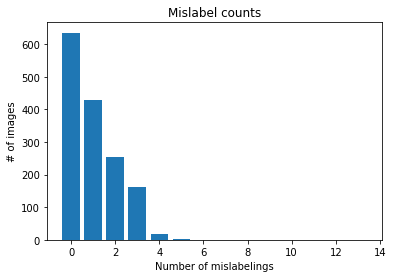

In [36]:
mislabels = get_mislabels_count_distribution(y_hats, y_trues)
print(mislabels)

plt.bar(np.arange(14, dtype = 'int'), mislabels)
plt.title('Mislabel counts')
plt.xlabel('Number of mislabelings')
plt.ylabel('# of images')


Let's get some examples of images where the original image was unlabeled but the classifier gave that image a label.

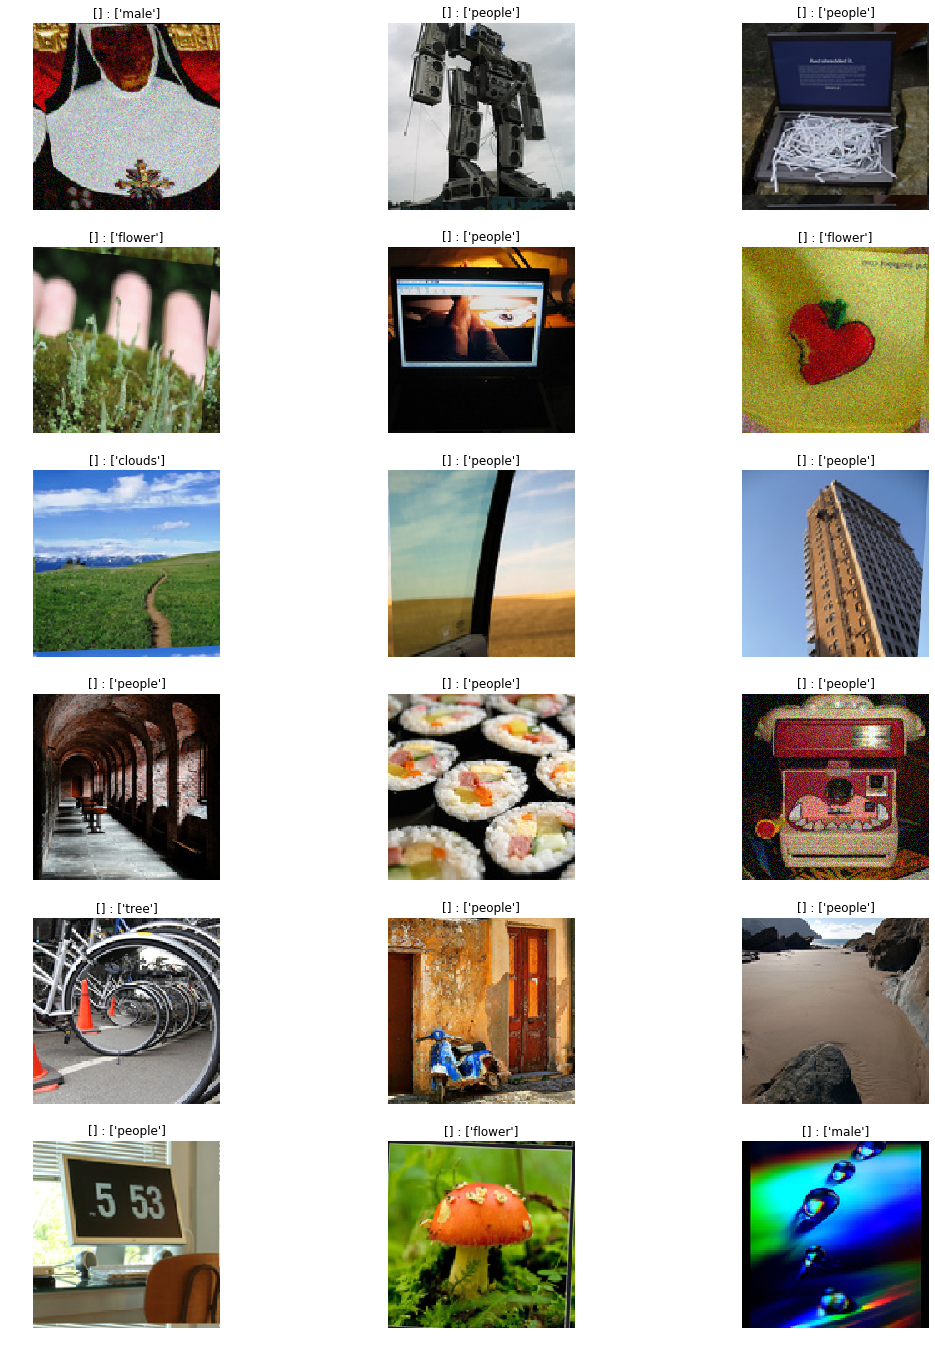

In [44]:
idx_set = get_indexes_for_mislabelled_images(testDataset, y_trues, y_hats, mislabels_count = 1, true_labels_count = 0, y_hat_labels_count = 1, sample_size = 18)
plot_imgs_with_labels(testDataset, idx_set, rows = 6, cols = 3)

Lets get some examples of images with most mislabelings:

[635 430 253 163  18   1   0   0   0   0   0   0   0   0]


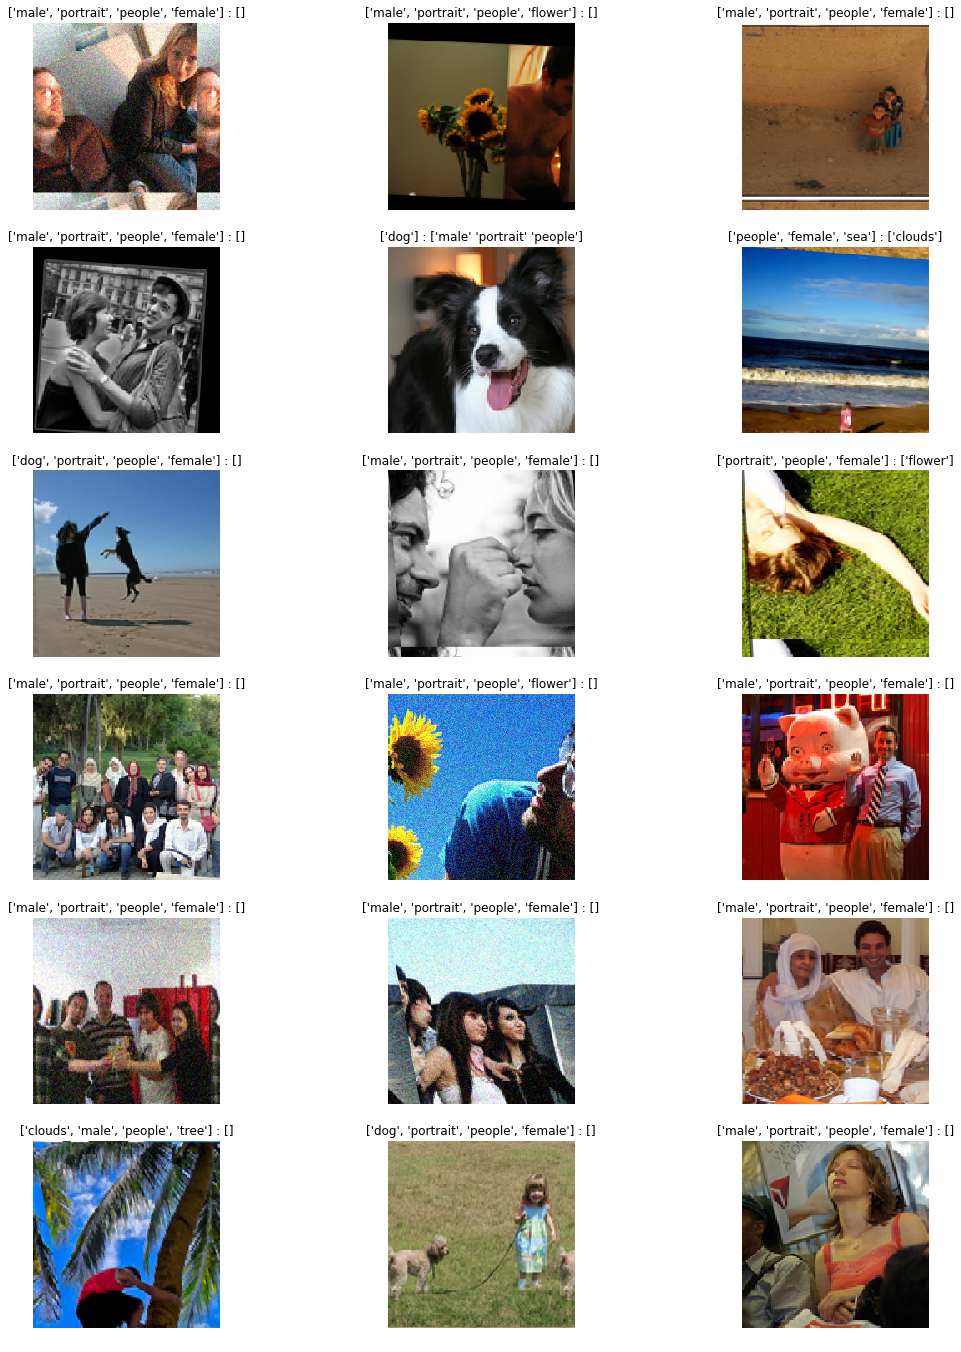

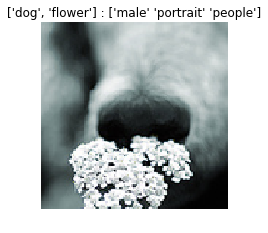

In [52]:
mislabels = get_mislabels_count_distribution(y_hats, y_trues)
print(mislabels)
idx = np.count_nonzero(mislabels != 0) - 1
idxs = [idx - 1, idx]

for idx in idxs:
    idx_set = get_indexes_for_mislabelled_images(testDataset, y_trues, y_hats, mislabels_count = idx, true_labels_count = 0, y_hat_labels_count = 0, sample_size = 18)
    plot_imgs_with_labels(testDataset, idx_set, rows = 6, cols = 3)

Lets calculate the number of cases where each label was misclassified. Each count marks a case where either the image had that label for real and the classifier didn't give it that label or classifier gave it that label even though the original image did not have it.

In [56]:
mislabelings_for_each_label = get_mislabels_count_for_each_label(y_hats, y_trues)

labels = list(map(lambda x: x[0], mislabelings_for_each_label))
counts = list(map(lambda x: x[1], mislabelings_for_each_label))

df = pd.DataFrame({'Label':labels, 'Count':counts}) 
print(df)

       Label  Count
0     clouds     99
1       male    230
2       bird     26
3        dog     43
4      river     12
5   portrait    243
6       baby      9
7      night     27
8     people    460
9     female    232
10       sea     14
11      tree     20
12       car     27
13    flower     60
